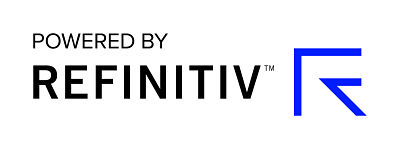

<center>
    <h3></h3>
    <h1> Derivatives - Prices</h1>
</center>

<center>
    <b>Gabriel Esquivel, Research Analyst</b>
</center>

<center>
    <i>January 2020</i>
</center>


## **<span style="color:blue">Contents</span>** 

* [Introduction](#Introduction)
* [Get the API Eikon Module](#Get-the-API-Eikon-Module)
* [Eikon Feed RICs](#Eikon-Feed-RICs)
    * [Exchange Rates from Eikon](#Exchange-Rates-from-Eikon)
* [Importing Check Values](#Importing-Check-Values)
    * [Merge between Check and Eikon Feed Rics](#Merge-between-Check-and-Eikon-Feed-Rics)
* [Validation DDBB](#Validation-DDBB)
    * [Merge between Check and Validation](#Merge-between-Check-and-Validation)
* [Money Markets DDBB](#Money-Markets-DDBB)    
    * [Merge between Check and Money Markets](#Merge-between-Check-and-Money-Markets)
* [Results from the 3 sources constrasted with Check](#Results-from-the-3-sources-constrasted-with-Check)   
* [Getting all data at once](#Getting-all-data-at-once)   
* [Quality Check](#Quality-Check)   
    * [Compare between Today and Yesterday Prices](#Compare-between-Today-and-Yesterday-Prices)
* [Stale Prices](#Stale-Prices)   



## **<span style="color:blue">Introduction</span>** 
<!-- blank line -->
----
<!-- blank line -->

The Eikon application integrates a Data API proxy that acts as an interface between the Eikon Data API Python library and the Eikon Data Platform. For this reason, the Eikon application must be running when you use the Eikon Data API Python library.

The main purpose of this Jupyter notebook is...

## **<span style="color:blue">Get the API Eikon Module</span>** 
<!-- blank line -->
----
<!-- blank line -->

Every application using the Eikon Data API must identify itself thanks to a Key called Application Key or App Key for short. This Key, that is a unique identifier for your application, must be created using the App Key Generator Eikon app that you can find in the Eikon App Library or via the toolbar of Eikon.

For more information about, click on the following link: 

https://developers.refinitiv.com/eikon-apis/eikon-data-api/quick-start

The main modules that will be used are: Pandas, Eikon API, Math , and xlsxwriter...

In [ ]:
import eikon as ek
ek.set_app_key('d241df4abf1248f78d100e148241dfc267401d0f')
import pandas as pd 
import os 
import glob
#import qgrid
from IPython.display import display
import ipywidgets as widgets
import numpy as np
import csv
import time 
from datetime import datetime, timedelta
import pymysql
import sys
import ipysheet
from ipysheet import from_dataframe, to_dataframe
import mysql.connector

## **<span style="color:blue">Eikon Feed RICs</span>** 

<p style='text-align: justify;'>The starting point of this Jupyter Notebook will be importing the cusips that the Derivatives team in Costa Rica receives daily. With these identifiers, the prices of each of the associated bonds in local currency will be extracted</p>

These identifiers are imported as a list of elements which will allow them to be used directly as an object within the `ek.get_data` function.

In [ ]:
instruments = []


with open("/Users/u6075486/Desktop/Davenport/NNS/CUSIPS NONEST/CUSIPS - NONEST.csv") as csvDataFile:
    csvReader = csv.reader(csvDataFile)
    for row in csvReader:
        for ric in row:
            instruments.append(ric)         
            
df,e = ek.get_data(instruments,['CURRENCY','PRIMACT_1'])
new_names = {'Instrument':'RIC', 'CURRENCY':'Currency', 'PRIMACT_1':'Price_Local_Currency'}
Prices_LC = df.rename(index = str, columns = new_names)
Prices_LC = Prices_LC[['Currency', 'RIC','Price_Local_Currency']]
Prices_LC.head()


<p style='text-align: justify;'>Once the cusips are imported and the prices in local currency of the associated bonds have been extracted, the cusips and the rics will be imported again to make a merge and obtain as a result a table where I get ric, cusip, price and currency</p>

This is done for convenience since the `ek.get_data` function does not accept dataframes. The table obtained as a result is shown below.

In [ ]:
os.chdir("/Users/u6075486/Desktop/Davenport/NNS")
nns = pd.read_csv("CUSIPS - RICS.csv",delimiter=',')
data_filtered = nns.loc[:,['CUSIP','RIC']]
Merge_Cusips_Rics = Prices_LC.merge(data_filtered, on='RIC', how = "left")
Merge_Cusips_Rics.head()

### **<span style="color:blue">Exchange Rates from Eikon</span>** 
<!-- blank line -->
----
<!-- blank line -->

To convert the prices from local currency bonds to US dollars, the following steps will be taken:

* Step 1: A list of all currencies from which the exchange rate can be calculated is imported. This was extracted from Global Currencies FX spot rate in Eikon, know as `FX=`

* Step 2: Make a table where the bid and ask exchange rate is obtained in US dollars, and the hour of the last time that the exchange rate was updated

* Step 3: Import a dictionary where is specified whether the exchange rate to USD is directly or indirectly. This will allow to build a table where we can get the currency, the exchange rate (Bid) and if it is calculated directly or indirectly. This table is named `Exchange_Rates_1`

* Step 4: With the table obtained in the previous step, a "vlookup" is made with the `.merge` function with the cusips that are initially used. This results in a table where it gets the following variables: Currency, RIC, Price in local currency, Cusip, Exchange rate (Bid) and Method (Direct or Indirect).This table is named `data_frame`

* Step 5: Finally, the exchange rate in USD is estimated. Once the calculation is made, a table is obtained with the RICs, Cusips and the price in USD. This table is named `Data_Prices`

In [ ]:
FX = []

with open("/Users/u6075486/Desktop/Davenport/RIC/RIC_FX.csv") as csvDataFile:
    csvReader = csv.reader(csvDataFile)
    for row in csvReader:
        for ric in row:
            FX.append(ric)

In [ ]:
df1,err = ek.get_data(FX,['BID','ASK','TIMACT'])
Currencies = df1['Instrument'].str[:3]
df1['Currencies'] = Currencies
df1.to_excel("FX.xlsx", sheet_name='FX')
df1.head()

In [ ]:
indirect_direct = []

with open("/Users/u6075486/Desktop/Davenport/Direct_Indirect/DIRECT_INDIRECT_FX.csv") as csvDataFile:
    csvReader = csv.reader(csvDataFile)
    for row in csvReader:
        for ric in row:
            indirect_direct.append(ric)            
            
DIR_INDIR = indirect_direct

df1['Direct_Indirect'] = indirect_direct

new_names2 = {'Instrument': 'RIC','BID':'FX_Bid', 'ASK':'FX_Ask','Currencies':'Currency','Direct_Indirect':'Direct_Indirect'}
Exchange_Rates = df1.rename(index = str, columns = new_names2)


Exchange_Rates_1 = Exchange_Rates.loc[:, ["FX_Bid", "Currency","Direct_Indirect" ]]
Exchange_Rates_1 = Exchange_Rates_1[['Currency','FX_Bid','Direct_Indirect']]
Exchange_Rates_1.head()

In [ ]:
data_frame = Merge_Cusips_Rics.merge(Exchange_Rates_1, on='Currency', how = "left")
data_frame.head()

In [ ]:
data_frame.loc[data_frame['Direct_Indirect'] == 'DIRECT', 'Price_USD'] = data_frame['Price_Local_Currency']/data_frame['FX_Bid']
data_frame.loc[data_frame['Direct_Indirect'] == 'INDIRECT', 'Price_USD'] = data_frame['Price_Local_Currency']*data_frame['FX_Bid']
data_frame.loc[data_frame['Direct_Indirect'] == '', 'Price_USD'] = 'No Value'
new_names3 = {'Price_USD':'Price'}
result_1 = data_frame.rename(index = str, columns = new_names3)
result_2 = result_1.loc[:,['RIC','Price','CUSIP']]
#result_2.to_excel("data_frame.xlsx", sheet_name='data_frame')
result_2.head()
new_names4 = {'Price':'Price USD'}
result_3 = data_frame.rename(index = str, columns = new_names4)
Data_Prices = result_3.loc[:,['RIC','Price_USD','CUSIP']]
Data_Prices.head()

## **<span style="color:blue">Importing Check Values</span>** 

<!-- blank line -->
----
<!-- blank line -->

Check is the portfolio in which the bonds that interest customers are located.Once we have this Cusips, there will be a .merge with each of the sources

In [ ]:
os.chdir("/Users/u6075486/Desktop/Davenport/Check")
check = pd.read_csv("Check_Davenport.csv")
check.head()
new_names5 = {'CUSIP / ISIN':'CUSIP'}
Check_1 = check.rename(index = str, columns = new_names5)
Check_1.head()

### **<span style="color:blue">Merge between Check and Eikon Feed Rics</span>** 

In [ ]:
data_frame_1 = Data_Prices.merge(Check_1, on='CUSIP', how = "inner")
data_frame_2 = data_frame_1.loc[:,['CUSIP','Price_USD']]
data_frame_1.to_excel("Eikon Feed.xlsx", sheet_name='EF')
data_frame_2.head()

## **<span style="color:blue">Validation DDBB</span>** 

In [ ]:
os.chdir("/Users/u6075486/Desktop/Davenport/Validation")
validation = pd.read_csv("Validation.txt",delimiter=';')
new_names6 = {'Price':'Price_USD'}
validation_1 = validation.rename(index = str, columns = new_names6)
validation_2 = validation_1.loc[:,['CUSIP','Price_USD']]
validation_2.head()

### **<span style="color:blue">Merge between Check and Validation</span>** 

In [ ]:
data_frame_validation = Check_1.merge(validation_2, on='CUSIP', how = "inner")
data_frame_validation_2 = data_frame_validation.loc[:,['CUSIP','Price_USD']]
data_frame_validation_2.to_excel("Validation Feed.xlsx", sheet_name='VA')
data_frame_validation_2.head()

## **<span style="color:blue">Money Markets DDBB</span>** 

In [ ]:
os.chdir(r"C:\Users\u6075486\Desktop\Davenport\New Adds")
extension = 'csv'

all_filenames = [
    j for j in glob.glob('*.{}'.format(extension))]

New_Adds = pd.concat([pd.read_csv(j) for j in all_filenames], sort = True)
New_Adds_NA= New_Adds.replace(np.nan, '', regex=True)
New_Adds_NA_1 = New_Adds_NA.loc[:,['Client Identifier','Price']]
new_names7 = {'Client Identifier':'CUSIP', 'Price':'Price_USD'}
New_Adds_NA_2 = New_Adds_NA_1.rename(index = str, columns = new_names7)
New_Adds_NA_2.head()

### **<span style="color:blue">Merge between Check and Money Markets</span>** 

In [ ]:
data_frame_Money_Market = New_Adds_NA_2.merge(Check_1, on='CUSIP', how = "inner")
data_frame_Money_Market_1 = data_frame_Money_Market.loc[:,['CUSIP','Price_USD']]
data_frame_Money_Market_1.to_excel("Money Market Feed.xlsx", sheet_name='MM')
data_frame_Money_Market_1.head()

## **<span style="color:blue">Results from the 3 sources constrasted with Check</span>** 

In [ ]:
data_frame_Eikon_1= data_frame_2
lenght1= len(data_frame_Eikon_1)
lenght1

In [ ]:
data_frame_validation_2.head()
lenght2= len(data_frame_validation_2)
lenght2

In [ ]:
data_frame_Money_Market_1.head()
lenght3= len(data_frame_Money_Market_1)
lenght3

## **<span style="color:blue">Getting all data at once</span>**

In [ ]:
import time 

os.chdir(r"C:\Users\u6075486\Desktop\Davenport\QA")
extension = 'csv'

data_joined = pd.concat([data_frame_Eikon_1, data_frame_validation_2, data_frame_Money_Market_1])
lenght4 = len(data_joined)
print(lenght4)
data_result=data_joined.drop_duplicates()

TodaysDate = time.strftime("%m-%d-%Y")
excelfilename = TodaysDate + ".xlsx"
data_result.to_excel(excelfilename, sheet_name='Result')    
    
#ata_result.to_excel('%m-%d-%Y.xlsx', sheet_name='Result')
lenght5= len(data_result)
lenght5
Today_Prices = data_result

Today_Prices = Today_Prices.round(decimals=3)

Today_Prices.head()

## **<span style="color:blue">Quality Check</span>**
<!-- blank line -->
----
<!-- blank line -->


In [ ]:
from datetime import datetime, timedelta
yestarday_file = datetime.strftime(datetime.now() - timedelta(1), '%m-%d-%Y' + ".xlsx")
yestarday_file

In [ ]:
path = "/Users/u6075486/Desktop/Davenport/QA"

os.chdir("/Users/u6075486/Desktop/Davenport/QA")

Yestarday = pd.read_excel(f'{path}/{yestarday_file}')
Yest_Prices = Yestarday.loc[:,['CUSIP','Price_USD']]

Yest_Prices = Yest_Prices.round(decimals=4)

Yest_Prices.head()

### **<span style="color:blue">Compare between Today and Previous Prices </span>** 
<!-- blank line -->
----
<!-- blank line -->

In [ ]:
Compare_table = Today_Prices.merge(Yest_Prices, on='CUSIP', how = "outer")
new_names_1 = {'Price_USD_x':'Today_Price', 'Price_USD_y':'Previous_Price'}
Compare_table_1 = Compare_table.rename(index = str, columns = new_names_1)

Difference = Compare_table_1['Today_Price'] - Compare_table_1['Previous_Price'] 

Abs_Difference = Difference.abs()

Compare_table_1['Abs_Difference'] = Abs_Difference
Compare_table_1['Difference'] = Difference

Table_Dif= Compare_table_1.sort_values('Abs_Difference', ascending = False)

Table_Dif['Check Box']= np.array("True", dtype='bool')

os.chdir("/Users/u6075486/Desktop/Davenport/Result")
data = Table_Dif.to_excel("True or False.xlsx")

### **<span style="color:blue">Final Prices </span>** 
<!-- blank line -->
----
<!-- blank line -->

In [ ]:
os.chdir("/Users/u6075486/Desktop/Davenport/Result")

Table_Last= pd.read_excel("True or False.xlsx",delimiter=',')

Table_Last= pd.read_excel("True or False.xlsx",delimiter=',')
Table_Last.loc[Table_Last['Check Box'] == True, 'Final_Price'] = Table_Last['Today_Price']
Table_Last.loc[Table_Last['Check Box'] == False, 'Final_Price'] = Table_Last['Previous_Price']
Table_Last.loc[Table_Last['Check Box'] == 'NaN', 'Final_Price'] = 'NaN'
Table_Last1 = Table_Last.loc[:,['CUSIP','Final_Price']]
Table_Last1.head()

## **<span style="color:blue">Stale Prices</span>**

In [6]:
def csv_to_mysql(laod_sql,host,user,password):
      try: 
        con = pymysql.connect(host=host,
                      user=user, 
                      password=password,
                      autocommit=True,
                      local_infile=1)
        
        print("Connected to DB:{}".format(host))
        cursor = con.cursor()
        cursor.execute(load_sql)
        print('Succuessfully loaded the table from csv.')
        con.close()
        
        remove_all_files
        
      except Exception as e:
        print('Error: {}'.format(str(e)))
        sys.exit(1)
        
load_sql = "LOAD DATA LOCAL INFILE 'c:/temp/test2.txt' INTO TABLE davenport.bonds\
 FIELDS TERMINATED BY ';'"
host = 'localhost'
user = 'root'
password = 'gabo200489'
csv_to_mysql(load_sql, host, user, password)

Connected to DB:localhost
Succuessfully loaded the table from csv.


In [7]:
connection = mysql.connector.connect(host = 'localhost',
                                    user = 'root',
                                    passwd = 'gabo200489',
                                    db = 'davenport')
bonds_table = pd.read_sql_query("select * from bonds", connection)
bonds_table

,CUSIP,Price,Spot,Date_Priced,Broker
0,000336462CH7,60.50,,10/08/2019,RIC_Quote\r\r
1,00254EMA7,108.00,,03/17/2020,Barclays\r\r
2,00279VCD5,99.35,,03/20/2020,Barclays\r\r
3,02687YAA9,97.00,,03/17/2020,Barclays\r\r
4,045491JU2,100.08,,06/28/2019,Navian\r\r
...,...,...,...,...,...
41520,XS2138370445,193.88,,03/25/2020,HSBC\r\r
41521,XS2138430876,96.79,,03/25/2020,HSBC\r\r
41522,XS2138684209,95.09,,03/25/2020,HSBC\r\r
41523,XS2138684381,100.23,,03/25/2020,HSBC\r\r


In [ ]:
def remove_all_files:
files = glob.glob(r'C:\Users\u6075486\Desktop\Test')
for f in files:
    os.remove(f)
    
remove_all_files